In [1]:
import numpy as np
import simtk.unit as unit
import matplotlib.pyplot as plt
import openmolecularsystems as oms

# El doble pozo como modelo asociación-disociación

unión: acoplo, asociación...
desunión: desacoplo, ruptura, disociación...

Esta unidad requiere conocer: qué es la dinámica de langevin, qué es y cómo se usa openmm.

## El potencial de doble pozo asimétrico

Simulamos una partícula en un potencial de doble pozo asimétrico, en tres dimensiones, definido como:

\begin{equation}
V(x,y,z)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x + \frac{1}{2}k\left( y^2 + z^2 \right)
\end{equation}

Más información en: unidad de dinámica molecular, openmolecularsystems, etc.

Haremos uso de los parámetros para el potencial:

In [2]:
Eo = 3.0 * unit.kilocalories_per_mole
a = 0.5 * unit.nanometers
b = 0.5 * unit.kilocalories_per_mole
k = 1.0*unit.kilocalories_per_mole/unit.angstrom**2

Y para el sistema:

In [3]:
mass = 35.453 * unit.amu

In [8]:
osystem = oms.DoubleWell(mass=35.453*unit.amu, Eo=3.0*unit.kilocalories_per_mole,
                         a=5*unit.angstrom, b=0.5*unit.kilocalories_per_mole,
                         k=1.0*unit.kilocalories_per_mole/unit.angstrom**2)

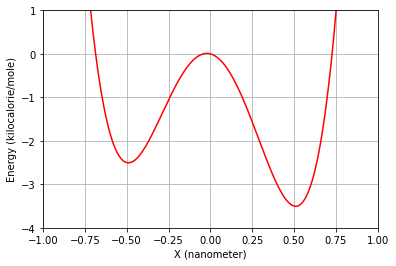

In [9]:
xyz_serie = np.zeros([200,3]) * unit.nanometers
xyz_serie[:,0] = np.linspace(-1.0, 1.0, num=200) * unit.nanometers

potential = osystem.evaluate_potential(xyz_serie)

plt.plot(xyz_serie[:,0], potential, 'r-')
plt.ylim(-4,1)
plt.xlim(-1,1)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.show()

In [32]:
initial_positions = np.zeros([1,3]) * unit.nanometers
initial_positions[0,0] = 0.56 * unit.nanometers

In [47]:
reporter = oms.tools.md.langevin_NVT(osystem, time=100.0*unit.nanoseconds,
                                     saving_timestep=10.0*unit.picoseconds,
                                     integration_timestep=0.1*unit.picoseconds,
                                     temperature=300.0*unit.kelvin,
                                     friction=1.0/unit.picoseconds,
                                     initial_coordinates=initial_positions,
                                     platform_name='CUDA')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13997.54it/s]


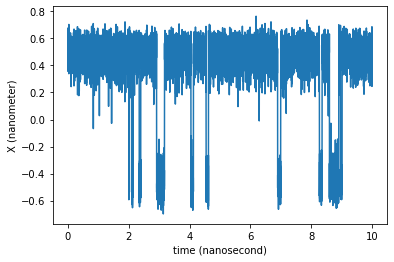

In [48]:
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), reporter['coordinates'][:,0,0])
plt.ylabel('X ({})'.format(reporter['coordinates'].unit))
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.show()

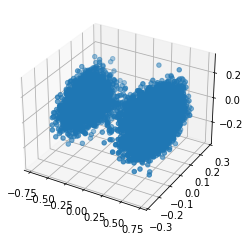

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(reporter['coordinates'][:,0,0], reporter['coordinates'][:,0,1],
           reporter['coordinates'][:,0,2])
ax.set_xlim3d([-0.8, 0.8])
ax.set_ylim3d([-0.3, 0.3])
plt.show()

In [15]:
def occupation_probability_density_1d(traj_x, x_range, n_bins):
    delta_x = (x_range[1]-x_range[0])/n_bins
    frequency = np.zeros(n_bins, dtype=int)
    for x in traj_x:
        bin_visited = int((x-x_range[0])/delta_x)
        frequency[bin_visited]+=1
    x_bins_centers = (x_range[0]+0.5*delta_x) + delta_x*np.arange(n_bins)
    bins_probability_density = (1.0/delta_x)*(frequency/frequency.sum())
    return x_bins_centers, bins_probability_density

In [16]:
traj_x = reporter['coordinates'][:,0,0]
x_center_bin, px = occupation_probability_density_1d(traj_x, [-1,1]*unit.nanometers, 50)

traj_y = reporter['coordinates'][:,0,1]
y_center_bin, py = occupation_probability_density_1d(traj_y, [-0.5,0.5]*unit.nanometers, 50)

traj_z = reporter['coordinates'][:,0,2]
z_center_bin, pz = occupation_probability_density_1d(traj_z, [-0.5,0.5]*unit.nanometers, 50)

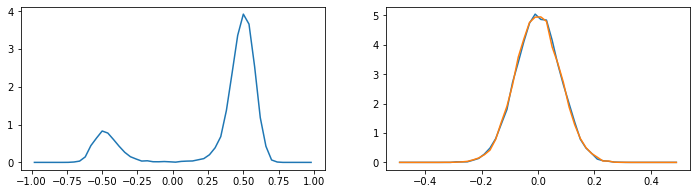

In [17]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches([12,3])
axs[0].plot(x_center_bin, px)
axs[1].plot(y_center_bin, py)
axs[1].plot(z_center_bin, pz)

plt.show()

Conocemos que podemos definir los estados asociado ("on" en ingles) y disociado ("off" en inglés) como las dos regiones del espacio conformacional separadas por el plano paralelo a $YZ$ ubicado en la coordenada $x_{b}$ en el eje $X$ correspondiente al máximo de la barrera del potencial.

In [18]:
xb = osystem.get_coordinates_maximum()[0][0]

Definiremos la constante de disociación como:

\begin{equation}
K_{D}=\frac{P_\textit{off}}{P_\textit{on}}
\end{equation}

Y la constante de asociación como:

\begin{equation}
K_{A}=\frac{P_\textit{on}}{P_\textit{off}}=\frac{1}{K_{D}}
\end{equation}

Donde $P_\textit{on}$ y $P_\textit{off}$ es la probabilidad de encontrar a la partícula en el pozo de la izquierda y en el de la derecha correspondientemente.

\begin{equation}
P_{on}=P(x\leq x_{b})
\end{equation}

\begin{equation}
P_{\textit{off}}=P(x>x_{b})
\end{equation}

De tal manera que por construcción:

\begin{equation}
1 = P_{\textit{off}}+P_{\textit{on}}
\end{equation}

Donde $x_b$ es la coordenada del máximo de la barrera.

Y estimaremos $K_{D}$ contando el número de eventos "on" ($m_\textit{on}$) y "off" ($m_\textit{off}$) observados a lo largo de nuestra partícula:

\begin{equation}
K_{D}=\frac{P_\textit{off}}{P_\textit{on}} \approx \frac{m_\textit{off}/M}{m_\textit{on}/M} =
\frac{m_\textit{off}}{m_\textit{on}}
\end{equation}

In [19]:
m_on = np.sum(traj_x<=xb)
m_off = traj_x.shape[0] - m_on
Kd = m_off/m_on

In [20]:
m_off/(m_on+m_off)

0.8173591320433978

In [21]:
Kd

4.475225841773884

Decimos que $P_\textit{on}$ y $P_\textit{off}$, y por la tanto $K_\textit{D}$ y $K_\textit{A}$, nos describen la termodinámica del sistema de dos estados. Pero no nos dicen nada de la cinética del proceso. Para ello debemos atender a las constantes cinéticas $K_\textit{on}$ y $K_\textit{off}$:

\begin{equation}
K_\textit{on} = P_{\textit{off}\rightarrow\textit{on}}
\end{equation}

\begin{equation}
K_\textit{off} = P_{\textit{on}\rightarrow\textit{off}}
\end{equation}


Donde $P_{\textit{off}\rightarrow\textit{on}}$ es la probabilidad de estando en el estado 'off', saltar al estado 'on', o escrito en términos de la probililidad condicionada:

\begin{equation}
P_{\textit{off}\rightarrow\textit{on}} = P(x>x_{b}| x\leq x_{b})
\end{equation}

Y $P_{\textit{on}\rightarrow\textit{off}}$ es la probabilidad de estando en el estado 'on', saltar al estado 'off':

\begin{equation}
P_{\textit{on}\rightarrow\textit{off}} = P(x\leq x_{b}| x>x_{b})
\end{equation}

Y podemos estimar estas probabilidades $P_{\textit{off}\rightarrow\textit{on}}$ y $P_{\textit{on}\rightarrow\textit{off}}$ contando en nuestra trayectoria el número de transiciones ${\textit{off}\rightarrow\textit{on}}$ ($m_{\textit{off}\rightarrow\textit{on}}$) y ${\textit{on}\rightarrow\textit{off}}$ ($m_{\textit{on}\rightarrow\textit{off}}$) observadas a lo largo de nuestra trayectoria:

\begin{equation}
K_\textit{on} = P_{\textit{off}\rightarrow\textit{on}} \approx \frac{m_{\textit{off}\rightarrow\textit{on}}}{m_\textit{off}}
\end{equation}

\begin{equation}
K_\textit{off} = P_{\textit{on}\rightarrow\textit{off}} \approx \frac{m_{\textit{on}\rightarrow\textit{off}}}{m_\textit{on}}
\end{equation}


In [22]:
m_off_to_on = 0
m_on_to_off = 0
traj_is_on = (traj_x<=xb)

for frame_index in range(traj_is_on.shape[0]-1):
    now = traj_is_on[frame_index]
    after = traj_is_on[frame_index+1]
    if now==True and after==False:
        m_on_to_off+=1
    elif now==False and after==True:
        m_off_to_on+=1

P_off_to_on = m_off_to_on/m_off
P_on_to_off = m_on_to_off/m_on

In [23]:
P_off_to_on

0.013273794959628089

In [24]:
P_on_to_off

0.05940323022173556

Observa que se cumple, en realidad para toda trayectoria que capture el comportamiento en equilibrio de cualquier sistema estocástico cerrado, que el número de transiciones observadas entre dos estados cualesquiera $i$ y $j$ en un sentido, es igual al número de transiciones observados en el sentido contrario: $m_{i \rightarrow j} = m_{j \rightarrow i}$. En el caso que estamos trabajando, al haber únicamente dos estados, el argumento se hace más fácil de entender. En un tiempo suficientemente largo el número de saltos $m_{\textit{on} \rightarrow \textit{off}}$ es igual a $m_{\textit{off} \rightarrow \textit{on}}$. La diferencia puede ser un salto, si es que la trayectoria observada no termina en el mismo estado en el que comenzó. Pero si el número de saltos observados es suficientemente largo, consideraremos esto un error no significativo en los números:

\begin{equation}
m_{\textit{on} \rightarrow \textit{off}} = m_{\textit{off} \rightarrow \textit{on}}
\end{equation}

Podemos reescribir esta exprexión de la siguiente manera:

\begin{equation}
\frac{m_\textit{on}}{M} \frac{m_{\textit{on} \rightarrow \textit{off}}}{m_\textit{on}} =
\frac{m_\textit{off}}{M} \frac{m_{\textit{off} \rightarrow \textit{on}}}{m_\textit{off}}
\end{equation}

O de otra manera... Si sabemos, que el número neto de transiciones entre los estados "on" y "off" son iguales en un sentido y en otro. Construyamos la igualdad asumiendo que no sabemos ni podemos calcular dicho número, pero sabemos el número total de pasos de intregación de nuestra trayectoria ($M$) y las probabilidades estacionarias y de transición que caracterizan nuestro sistema:

\begin{equation}
M P_\textit{on} P_{\textit{on} \rightarrow \textit{off}} =
M P_\textit{off} P_{\textit{off} \rightarrow \textit{on}}
\end{equation}


De ambas maneras lo que obtenemos es **la ecuación de balance detallado**, que relaciona la termodinámica y la cinética. Esta expresión se cumple para cualquier sistema cerrado en equilibrio, entre cualquier par de estados:

\begin{equation}
P_\textit{on} P_{\textit{on} \rightarrow \textit{off}} =
P_\textit{off} P_{\textit{off} \rightarrow \textit{on}}
\end{equation}

O escrito de otra manera:

\begin{equation}
\frac{P_\textit{on}}{P_\textit{off}} = \frac{P_{\textit{off} \rightarrow \textit{on}}}{P_{\textit{on} \rightarrow \textit{off}}}
\end{equation}


Vamos a detenernos un momento en esta expresión porque merece algunos comentarios. En primer lugar vemos que las constantes $K_{D}$ y $K_{A}$ pueden ser calculadas de las cinéticas:

\begin{equation}
K_{A} = \frac{K_\textit{on}}{K_\textit{off}}
\end{equation}

Por otro lado vemos que la termodinámica no determina la cinética y vice versa. Es decir, podemos tener nuestro doble pozo en un estado termodinámico que haga que los estados 'on' y 'off' tengan cierta probabilidad de ocupación, pero esto no nos dice absolutamente nada sobre cuan fácil o rápido es transitar entre ambos estados. Sólo nos habla del cociente de las constantes cinéticas, pero hay infinitas combinaciones de valores para la pareja de constantes $K_\textit{on}$ y $K_\textit{off}$ compatibles con la misma constante de disociación. O con un lenguaje más aterrizado en el diseño de moléculas con potencial farmacológico: podemos convenir que la constante $K_{D}$ es un parámetro a optimizar con el diseño -queremos moléculas cuya probabilidad de estar asociadas al receptor sea alta-; pero esto no nos dice nada de la facilidad con la que los complejos receptor-ligando se forman o rompen, ni por lo tanto nos dice nada a cerca del tiempo de vida medio del complejo receptor-ligando. Y, ¿qué será más importante optimizar para tener un buen candidato a molécula idonea con propiedades farmacológicas?¿El cociente $P_\textit{on} / P_\textit{off}$ o el tiempo de vida media del complejo $\propto 1 / P_{\textit{on} \rightarrow \textit{off}}$?

Ya tenemos caracterizado nuestro modelo cinético de dos estados, construido de la observación durante un tiempo limitado del comportamiento dinámico de una partícula en el potencial de doble pozo. Ahora, debemos preguntarnos... ¿Cúan confiable es nuestra caracterización del sistema?¿Cúal es la calidad de las observaciones o de las predicciones que podemos hacer? Estas preguntas deben acompañar siempre al resultado de nuestro trabajo, a nuestras afirmaciones o respuestas en cualquier contexto relacionado con nuestro proyecto de investigación.

Ideas de las siguientes unidades:
    - Nuestras constantes cinéticas y termodinámicas nos dan un buen modelo?
    - Predicción de la termodinámica desde la mecánica estadística
    - Predicción de la cinética desde la teoría de procesos estocásticos
    
En las conclusiones finales poner preguntas como:
- Estará la termodinámica y cinética de un proceso de unión proteina-ligando bien descrito por un proceso de dos estados?

- Es necesaria una dinámica para sacar Kd? Para qué necesito una dinámica fuerza bruta si sólo voy a sacar Kd que es un observable de equilibrio, un observable de la termodinámica. Si sólo quiero predicir la termodinámica y no la cinética hay muchas otras técnicas. La primera y más viejita: monte carlo...